# Lab 9

**Lecture**: Deep Learning (Prof. Dr. David Rügamer, Emanuel Sommer)

In the first part of the lab, we will analytically derive the backpropagation equations for a simple RNN.
Then, in the second part, we will implement forward and backward propagation functions for a simple RNN-model,
and train to  predict the future temperature based on past weather metrics.

## Imports

In [1]:
import csv
import urllib.request
from operator import itemgetter
from typing import Tuple, Dict

import torch
from torch import Tensor
from torch.distributions import Normal

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('png', 'pdf')

## Exercise 1
In this part, we derive the backpropagation equations for a simple RNN from forward propagation equations. For simplicity, we will focus on a single input sequence $\textbf{x}^{[1]},\ldots,\textbf{x}^{[\tau]}$. The forward pass in a RNN with hyperbolic tangent activation at time $t$ is given by:
\begin{align}
\textbf{h}^{[t]} &= \tanh {(\textbf{W} \textbf{h}^{[t-1]} + \textbf{U} \textbf{x}^{[t]} + \textbf{b})} \\
\hat{\textbf{y}}^{[t]} &= \textbf{V}\textbf{h}^{[t]}+\textbf{c}
\end{align}
where the parameters are the bias vectors $\textbf{b}$ and $\textbf{c}$ along with the weight matrices $\textbf{U}$,$\textbf{V}$ and $\textbf{W}$, respectively, for input-to-hidden, hidden-to-output and hidden-to-hidden connections. As we will use RNN for a regression problem in the of the exercise, we do not use an activation function in order to compute the output $\hat{\textbf{y}}^{[t]}$ (at time $t$).

The loss is defined as:
\begin{equation}
\mathcal{L}=\sum_{t=1}^{\tau}\mathcal{L}\left(\textbf{y}^{[t]}, \hat{\textbf{y}}^{[t]}\right)
\end{equation}

Show that:
\begin{align}
\nabla_{\textbf{h} ^{[\tau]}} \mathcal{L}
&= \textbf{V}^{T} (\nabla_{\hat{\textbf{y}} ^{[\tau]}}\mathcal{L}) \\
\nabla_{\textbf{h} ^{[t]}}  \mathcal{L}
&= \textbf{W}^{T} \text{diag}\bigg(1-\big(\textbf{h}^{[t+1]}\big)^{^2} \bigg)(\nabla_{\textbf{h}{^{[t+1]}}}{{L}}) + \textbf{V}^{T} (\nabla_{\hat{\textbf{y}} ^{[t]}}\mathcal{L}) \\
\nabla_\textbf{c}  \mathcal{L}
&= \sum_{t=1}^{\tau}\nabla_{\hat{\textbf{y}}{^{[t]}}}{{\mathcal{L}}} \\
\nabla_\textbf{b}  \mathcal{L}
&= \sum_{t=1}^{\tau} \text{diag}\bigg(1-\big(\textbf{h}^{[t]}\big)^{2} \bigg) \nabla_{\textbf{h}^{[t]}}\mathcal{L} \\
\nabla_\textbf{V}  \mathcal{L}
&=\sum_{t=1}^{\tau}(\nabla_{\hat{\textbf{y}}{^{[t]}}}{\mathcal{L}})  \textbf{h}^{{[t]}^{T}} \\
\nabla_\textbf{W}  \mathcal{L}
&=\sum_{t=1}^{\tau} \text{diag}\bigg(1-\big(\textbf{h}^{[t]}\big)^{2} \bigg)\ (\nabla_{\textbf{h}{^{[t]}}}{{\mathcal{L}}}) \textbf{h}^{{[t-1]}^{T}} \\
\nabla_\textbf{U}  \mathcal{L}
&= \sum_{t=1}^{\tau} \text{diag}\bigg(1-\big(\textbf{h}^{[t]}\big)^{2} \bigg)(\nabla_{\textbf{h}{^{[t]}}}{{\mathcal{L}}}) \textbf{x}^{{[t]}^{T}}
\end{align}

Hint 1 (chain rule for vector calculus): given a vector $\textbf{x}\in\mathbb{R}^n$ and two functions $f:\mathbb{R}^n\rightarrow\mathbb{R}^m$ and $g:\mathbb{R}^m\rightarrow\mathbb{R}$, call the outputs $\hat{\textbf{y}}=f(\textbf{x})$ and $z=g(\hat{\textbf{y}})=g(f(\textbf{x}))$, then the following holds:

\begin{equation}
\nabla_{\textbf{x}} z
=
\nabla_{\textbf{x}}\hat{\textbf{y}}
\cdot
\nabla_{\hat{\textbf{y}}} z
\end{equation}
where $\nabla_{\hat{\textbf{y}}} z\in\mathbb{R}^m$ and $\nabla_{\textbf{x}}\hat{\textbf{y}}\in\mathbb{R}^n\times\mathbb{R}^m$.

Hint 2: draw a computational graph representing the computation performed by the RNN unrolled over time, then use this graph to compute the gradients: multiply gradients via the chain rule when traversing edges, and sum the gradients obtained along each path from the loss to the item you are differentiating against.

### Solution

![](../utils/09-lab-comp-graph.png)

The figure shows a simplified computational graph for three steps of a RNN. Biases omitted for simplicity.

There is only one path connecting $\textbf{h}^{[\tau]}$ to the loss:

\begin{equation}
\nabla_{\textbf{h}^{[\tau]}} \mathcal{L}
= \nabla_{\textbf{h}^{[\tau]}}  \hat{\textbf{y}}^{[\tau]} \cdot \nabla_{\hat{\textbf{y}} ^{[\tau]}}\mathcal{L}
= \textbf{V}^{T}\cdot \nabla_{\hat{\textbf{y}} ^{[\tau]}}\mathcal{L}
\end{equation}

while every other hidden activation influences the loss via its associated output and the following hidden activation, thus:

\begin{equation}
\nabla_{\textbf{h}^{[t]}} \mathcal{L}
= \nabla_{\textbf{h}^{[t]}} \hat{\textbf{y}}^{[t]} \cdot \nabla_{\hat{\textbf{y}} ^{[t]}}\mathcal{L}
+ \nabla_{\textbf{h}^{[t]}} \textbf{h}^{[t+1]} \cdot \nabla_{\textbf{h}^{[t+1]}} \mathcal{L}
\end{equation}

The first term is analogous to above, while to find $\nabla_{\textbf{h}^{[t]}} \textbf{h}^{[t+1]}$ we need to apply the chain rule again:
\begin{equation}
\nabla_{\textbf{h}^{[t]}} \textbf{h}^{[t+1]}
=\nabla_{\textbf{h}^{[t]}} \tanh\left(\textbf{W} \textbf{h}^{[t]} + \textbf{U} \textbf{x}^{[t+1]} + \textbf{b}\right)
=\textbf{W}^T\cdot\text{diag}\left(1-{\textbf{h}^{[t+1]}}^2\right)
\end{equation}

Therefore,

\begin{equation}
\nabla_{\textbf{h}^{[t]}} \mathcal{L}
= \textbf{V}^{T} \cdot \nabla_{\hat{\textbf{y}} ^{[t]}}\mathcal{L}
+\textbf{W}^T\cdot\text{diag}\left(1-{\textbf{h}^{[t+1]}}^2\right) \cdot \nabla_{\textbf{h}^{[t+1]}} \mathcal{L}
\end{equation}

where we do not expand $\nabla_{\textbf{h}^{[t+1]}} \mathcal{L}$ further as that is carried over during backpropagation (it corresponds to the $\delta$ in lab 4).

We now compute the gradients with respect to the parameters of the network, starting with the easy biases. $\textbf{c}$ is used to compute $\hat{\textbf{y}}^{[t]}$ for every $t$, thus:
\begin{equation}
\nabla_\textbf{c} \mathcal{L}
=\sum_{t=1}^\tau
\nabla_{\textbf{c}}\hat{\textbf{y}}^{[t]}\cdot\nabla_{\hat{\textbf{y}}^{[t]}}\mathcal{L}
=\sum_{t=1}^\tau\nabla_{\hat{\textbf{y}}^{[t]}}\mathcal{L}
\end{equation}
Similarly, $\textbf{b}$ is used to compute $\textbf{h}^{[t]}$, therefore:
\begin{equation}
\nabla_\textbf{b} \mathcal{L}
=\sum_{t=1}^\tau
\nabla_{\textbf{b}}\textbf{h}^{[t]}\cdot\nabla_{\textbf{h}^{[t]}}\mathcal{L}
=\sum_{t=1}^\tau
\text{diag}\left(1-{\textbf{h}^{[t]}}^2\right)
\cdot\nabla_{\textbf{h}^{[t]}}\mathcal{L}
\end{equation}

Moving on to the three weight matrices, we have:
\begin{equation}
\nabla_\textbf{V} \mathcal{L}
=\sum_{t=1}^\tau
\nabla_{\textbf{V}^{[t]}} \hat{\textbf{y}}^{[t]}\cdot\nabla_{\hat{\textbf{y}}^{[t]}}\mathcal{L}
\end{equation}
where we use $\nabla_{\textbf{V}^{[t]}} \hat{\textbf{y}}^{[t]}$ to denote the gradient of $\hat{\textbf{y}}^{[t]}$ with respect to $\textbf{V}$ *without* backpropagating, i.e., the contribution of $\textbf{V}$ only at time $t$. In other words, you can think of $\textbf{V}^{[1]},\ldots,\textbf{V}^{[t]}$ as dummy variables that all equal $\textbf{V}$. Note that we must now deal with tensors: let $\textbf{V}^{[t]}\in\mathbb{R}^{n\times m}$, then $\nabla_{\textbf{V}^{[t]}} \hat{\textbf{y}}^{[t]}\in\mathbb{R}^{n\times m\times n}$, so that, since $\nabla_{\hat{\textbf{y}}^{[t]}}\mathcal{L}\in\mathbb{R}^{n}$, $\nabla_\textbf{V} \mathcal{L}\in\mathbb{R}^{n\times m}$ (the last dimension disappears due to the dot products, just like normal matrix multiplication). Let's analyze each item of the final gradient:
\begin{align}
\left(\nabla_V \mathcal{L}\right)_{ij}
&=\frac{\partial}{\partial\textbf{V}_{ij}}\mathcal{L} \\
&=\sum_{t=1}^{\tau}\sum_{k=1}^n \frac{\partial \mathcal{L}}{\partial y^{[t]}_k}\cdot\frac{\partial y^{[t]}_k}{\partial V^{[t]}_{ij}} \\
&=\sum_{t=1}^{\tau}\sum_{k=1}^n \frac{\partial \mathcal{L}}{\partial y^{[t]}_k}\cdot
\frac{\partial}{\partial V^{[t]}_{ij}}\sum_{\ell=1}^m V^{[t]}_{k\ell}h^{[t]}_{\ell} \\
&=\sum_{t=1}^{\tau}\sum_{k=1}^n \frac{\partial \mathcal{L}}{\partial y^{[t]}_k}\cdot
\delta_{ik}h^{[t]}_j \\
&=\sum_{t=1}^{\tau}
\frac{\partial \mathcal{L}}{\partial y^{[t]}_i}\cdot
h^{[t]}_j
\end{align}
Therefore, via the outer product:
\begin{equation}
\nabla_\textbf{V} \mathcal{L}=\sum_{t=1}^{\tau}\nabla_{\hat{\textbf{y}}^{[t]}}\mathcal{L}\cdot {\textbf{h}^{[t]}}^T
\end{equation}
A faster way of reaching the same result is via:
\begin{equation}
\nabla_\textbf{V} \mathcal{L}
=\sum_{t=1}^{\tau}
\sum_{i=1}^n
\nabla_{\textbf{V}}y_i^{[t]}
\cdot
\nabla_{y_i^{[t]}}\mathcal{L}
\end{equation}
and noticing that $\nabla_{\textbf{V}}y_i^{[t]}$ is a matrix with all zeros except for row $i$ which equals ${\textbf{h}^{[t]}}^T$.

Moving on to $\textbf{W}$, using the same insight, we have:
\begin{equation}
\nabla_{\textbf{W}}\mathcal{L}
=\sum_{t=1}^{\tau} \nabla_{\textbf{W}}\textbf{h}^{[t]}\cdot \nabla_{\textbf{h}^{[t]}}\mathcal{L}
=\sum_{t=1}^{\tau} \sum_{i=1}^{n} \nabla_{\textbf{W}}h_i^{[t]}\cdot \nabla_{h_i^{[t]}}\mathcal{L}
\end{equation}
where the $i$-th row of $\nabla_{\textbf{W}}h_i^{[t]}$ equals, by the chain rule,
\begin{equation}
\nabla_{\textbf{W}}h_i^{[t]}
=\left(1-{{h}_i^{[t]}}^2\right)\cdot{\textbf{h}^{[t-1]}}^T
\end{equation}
therefore:
\begin{equation}
\nabla_{\textbf{W}}\mathcal{L}
=\sum_{t=1}^{\tau} \sum_{i=1}^{n} \nabla_{\textbf{W}}h_i^{[t]}\cdot \nabla_{h_i^{[t]}}\mathcal{L}
=\sum_{t=1}^{\tau}
\text{diag}\left(1-{\textbf{h}^{[t]}}^2\right)\cdot\nabla_{\hat{\textbf{y}}^{[t]}}\mathcal{L} \cdot{\textbf{h}^{[t-1]}}^T
\end{equation}

Finally, in a similar way,
\begin{equation}
\nabla_{\textbf{U}}\mathcal{L}
=\sum_{t=1}^{\tau} \nabla_{\textbf{U}}\textbf{h}^{[t]}\cdot \nabla_{\textbf{h}^{[t]}}\mathcal{L}
=\sum_{t=1}^{\tau} \sum_{i=1}^{n} \nabla_{\textbf{U}}h_i^{[t]}\cdot \nabla_{h_i^{[t]}}\mathcal{L}
=\sum_{t=1}^{\tau}
\text{diag}\left(1-{\textbf{h}^{[t]}}^2\right)\cdot\nabla_{\hat{\textbf{y}}^{[t]}}\mathcal{L} \cdot{\textbf{x}^{[t]}}^T
\end{equation}


## Exercise 2
In the next exercise, we are going to be estimating only the temperature value of the next hour from the given past 24 hours of weather-related information.
Thus we will not be computing any intermediate output from the RNN and only one scalar value at the final step. Additionally, we will use mean square error as a loss function.

Given this information, show that:

\begin{align}
\nabla_{\textbf{h} ^{[\tau]}} \mathcal{L}
&=2(\hat y-y) \textbf{V}^{T} \\
\nabla_{\textbf{h} ^{[t]}}\mathcal{L}
&= \textbf{W}^{T} \cdot \text{diag}\bigg(1-{\textbf{h}^{[t+1]}}^{2} \bigg)\cdot\nabla_{\textbf{h}{^{[t+1]}}}{\mathcal{L}} \\
\nabla_{\textbf{c}} \mathcal{L}
&= 2(\hat y-y) \\
\nabla_\textbf{V} \mathcal{L}
&= 2(\hat y-y) \textbf{h}^{{[\tau]}^{T}}
\end{align}


### Solution

In the first formula we can directly expand the gradient of the loss:
\begin{equation}
\nabla_{\textbf{h}^{[\tau]}} \mathcal{L}
= \textbf{V}^{T}\cdot \nabla_{\textbf{y} ^{[\tau]}}\mathcal{L}
= \textbf{V}^{T}\cdot 2(y-\hat{y})
\end{equation}

In the other cases, since only the last output is connected to the loss, the formulas developed above do not need to consider the paths connecting intermediate outputs. Therefore,
\begin{equation}
\nabla_{\textbf{h}^{[t]}} \mathcal{L}
=\nabla_{\textbf{h}^{[t]}} \textbf{h}^{[t+1]} \cdot \nabla_{\textbf{h}^{[t+1]}} \mathcal{L}
=\textbf{W}^T\cdot\text{diag}\left(1-{\textbf{h}^{[t]}}^2\right) \cdot \nabla_{\textbf{h}^{[t+1]}} \mathcal{L}
\end{equation}
for the bias:
\begin{equation}
\nabla_{\textbf{c}} \mathcal{L}
=\nabla_{\textbf{c}}\textbf{y}^{[\tau]}\cdot \nabla_{\textbf{y}^{[\tau]}}\mathcal{L}
= 2(\hat y-y)
\end{equation}
and for the last weight matrix:
\begin{equation}
\nabla_\textbf{V} \mathcal{L}
=\nabla_\textbf{V} \textbf{y}^{[\tau]}\cdot \nabla_{\textbf{y}^{[\tau]}}\mathcal{L}
= 2(\hat y-y) \textbf{h}^{{[\tau]}^{T}}
\end{equation}
where $\textbf{V}$ now has only one row since the network outputs scalars.


## Exercise 3
In this exercise, we will implement forward and backward propagation steps of the simple RNN and train it on a real data.
We will stick to the notation the we used in the first part of the exercise.

### Prepare the data
In this exercise we will develop a model that estimates the temperature of the following hour from different weather parameters in the last 24 hours.
The dataset includes the features described in the table below.

We download the dataset from github and print out the first rows and the dimensions of file.
We will use DEWP, TEMP, PRES, cbwd, Iws, Is, Ir features as input and not the pollution, since pm2.5 contains some NA values we do not want to deal with.

| Column number | Column name | Column description               |
|---------------|-------------|----------------------------------|
| 1             | No          | Row number                       |
| 2             | year        | Year                             |
| 3             | month       | Month                            |
| 4             | day         | Day                              |
| 5             | hour        | Hour                             |
| 6             | pm2.5       | Pollution in PM2.5 concentration |
| 7             | DEWP        | Dew Point                        |
| 8             | TEMP        | Temperature                      |
| 9             | PRES        | Pressure                         |
| 10            | cbwd        | Combined wind direction          |
| 11            | Iws         | Cumulated wind speed             |
| 12            | Is          | Cumulated hours of snow          |
| 13            | Ir          | Cumulated hours of rain          |


In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv'
response = urllib.request.urlopen(url)
lines = [l.decode('utf-8') for l in response.readlines()]
data_list = [row for row in csv.reader(lines)]

The first row contains the header/column names:

In [3]:
print(data_list[0])

['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']


As stated before, we will use DEWP, TEMP, PRES, cbwd, Iws, Is, Ir as features. Thus, we select the correct columns and create a tensor.

In [4]:
# Let's remove the header now.
# We will also only handle the first 43000 entries to comply with the original R exercise ;)
data_list = data_list[1:43001]

# We then remove the last day, because it is missing observations
num_rows = len(data_list) - len(data_list) % 24
data_list = data_list[:num_rows]

filtered_data_list = []
for row in data_list:
    selection = itemgetter(6, 7, 8, 10, 11, 12)(row)
    selection = [float(elem) for elem in selection]
    filtered_data_list.append(selection)

dataset = torch.tensor(filtered_data_list, dtype=torch.float)
print('The dataset has {} columns and {} features.'.format(*dataset.shape))
print(dataset[:5])

# Let's delete the old stuff. We don't need it anymore
del data_list, filtered_data_list

The dataset has 42984 columns and 6 features.
tensor([[ -21.0000,  -11.0000, 1021.0000,    1.7900,    0.0000,    0.0000],
        [ -21.0000,  -12.0000, 1020.0000,    4.9200,    0.0000,    0.0000],
        [ -21.0000,  -11.0000, 1019.0000,    6.7100,    0.0000,    0.0000],
        [ -21.0000,  -14.0000, 1019.0000,    9.8400,    0.0000,    0.0000],
        [ -20.0000,  -12.0000, 1018.0000,   12.9700,    0.0000,    0.0000]])


The data is already sorted by time, from oldest to newest observation. We then create a test set using the last 20% of days:

In [5]:
num_train_samples = (
    int(0.8 * len(dataset) - len(dataset) % 24)
)

data_train = dataset[:num_train_samples]
data_test = dataset[num_train_samples:]

We now standardize the data to have zero mean and unit standard deviation:

In [6]:

means = (
    torch.mean(data_train, dim=0)
)

stds = (
    torch.std(data_train, dim=0)
)

data_train = (
    (data_train - means) / stds
)

data_test = (
    (data_test - means) / stds
)

# Check if standardization worked
print('This should be close to zero:', torch.mean(data_train, dim=0))
print('This should be close to one:', torch.std(data_train, dim=0))

This should be close to zero: tensor([-3.5499e-09, -3.2837e-08, -2.3057e-06, -1.6640e-08, -2.2187e-10,
         2.5182e-08])
This should be close to one: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


We now create a function to return a single random sequence of 24 contiguous observations along with the temperature to predict:


In [7]:

def get_random_day(data: Tensor) -> Tuple[Tensor, Tensor]:
    """Get 24 random contiguous hours from the dataset."""
    start_idx = (
    torch.randint(len(data) - 25, (1,))
    )

    x = data[start_idx: start_idx + 24]
    y = data[start_idx + 24, 1]
    # The magic number 1 above corresponds to the second column in the features, which is temperature.

    return x, y

# Check for correct shape
x, y = get_random_day(data_train)
assert x.shape == (24, 6) and y.shape == (1,)

### RNN implementation
Let's define our own RNN module and initialize U, W, V, b and c weights randomly:

In [8]:

class RNN:
    def __init__(self, hidden_state_size: int = 10, num_features: int = 6) -> None:
        self.hidden_state_size = hidden_state_size
        self.num_features = num_features

        init_distribution = Normal(0, 0.001)

        self.u = init_distribution.sample((hidden_state_size, num_features))
        self.w = init_distribution.sample((hidden_state_size, hidden_state_size))
        self.v = init_distribution.sample((hidden_state_size,))
        self.b = torch.zeros(hidden_state_size)
        self.c = torch.zeros(1)

    # We will now define a function for the forward propagation,
    # which will return the prediction of the network as well as all intermediate hidden states:
    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        """Pass a timeseries through the RNN."""
        h_dims = (
            len(x) + 1, self.hidden_state_size
        )
        h = torch.zeros(h_dims)

        for i in range(len(x)):
            h[i + 1] = torch.tanh(self.u @ x[i] + self.w @ h[i] + self.b)

        y = (
            self.v @ h[-1] + self.c
        )
        return h[1:], y

    def __call__(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        return self.forward(x)

    # We now define functions computing the gradient for each parameter of the 
    # network separately, starting from the hidden states:

    def _compute_grad_h(self, y_true: Tensor, y_pred: Tensor, hidden: Tensor) -> Tensor:
        """Compute the gradient w.r.t. h"""
        grad_h = (
            torch.zeros_like(hidden)
        )

        grad_h[-1] += 2 * (y_pred - y_true) * self.v.T

        for i in reversed(range(len(hidden) - 1)):
            grad_h[i] += self.w.transpose(0, 1) @ torch.diag(1 - hidden[i + 1]**2) @ grad_h[i + 1]

        return grad_h

    def _compute_grad_c(self, y_true: Tensor, y_pred: Tensor) -> Tensor:
        """Compute the gradient w.r.t. c. (The bias of the output layer)"""
        return 2 * (y_pred - y_true)

    def _compute_grad_b(self, hidden: Tensor, grad_h: Tensor) -> Tensor:
        """Compute the gradient w.r.t. b. (The bias of the recurrent layer)"""
        grad_b = torch.zeros_like(self.b)
        for i in range(1, len(hidden)):
            grad_b += torch.diag(1 - hidden[i]**2) @ grad_h[i]
        return grad_b

    def _compute_grad_v(self, y_true: Tensor, y_pred: Tensor, hidden: Tensor) -> Tensor:
        """Compute the gradient w.r.t. v. (The bias of the output weights)"""
        return 2 * (y_pred - y_true) * hidden[-1]

    def _compute_grad_w(self, hidden: Tensor, grad_h: Tensor) -> Tensor:
        """Compute the gradient w.r.t. w. (The hidden-to-hidden weights)"""
        grad_w = torch.zeros_like(self.w)
        for i in range(1, len(hidden)):
            grad_w += torch.diag(1 - hidden[i]**2) @ grad_h[i].unsqueeze(-1) @ hidden[i - 1].unsqueeze(0)
        return grad_w

    def _compute_grad_u(self, hidden: Tensor, grad_h: Tensor, x: Tensor) -> Tensor:
        """Compute the gradient w.r.t. u. (The input-to-hidden weights)"""
        grad_w = torch.zeros_like(self.u)
        for i in range(1, len(hidden)):
            grad_w += torch.diag(1 - hidden[i]**2) @ grad_h[i].unsqueeze(-1) @ x[i - 1].unsqueeze(0)
        return grad_w

    def get_gradients(self, x: Tensor, y_true: Tensor, y_pred: Tensor, hidden: Tensor) -> Dict:
        """Obtain all gradients for a prediction."""
        grad_h = self._compute_grad_h(y_true, y_pred, hidden)
        return {
            "grad_c": self._compute_grad_c(y_true, y_pred),
            "grad_b": self._compute_grad_b(hidden, grad_h),
            "grad_v": self._compute_grad_v(y_true, y_pred, hidden),
            "grad_w": self._compute_grad_w(hidden, grad_h),
            "grad_u": self._compute_grad_u(hidden, grad_h, x)
        }

# Compute some dummy values to see if your implementation works without throwing errors.
# (And in practice please use unit tests!)
rnn = RNN()
x, y = get_random_day(data_train)
h, y_hat = rnn(x)
grad_h = rnn._compute_grad_h(y, y_hat, h)
grad_c = rnn._compute_grad_c(y, y_hat)
grad_b = rnn._compute_grad_b(h, grad_h)
grad_v = rnn._compute_grad_v(y, y_hat, h)
grad_w = rnn._compute_grad_w(h, grad_h)
grad_u = rnn._compute_grad_u(h, grad_h, x)

# Check if your implementation returns the correct shapes
assert h.shape == (24, 10)
assert y.shape == (1, )
assert grad_h.shape == (24, 10)
assert grad_c.shape == (1, )
assert grad_b.shape == (10, )
assert grad_v.shape == (10, )
assert grad_w.shape == (10, 10)
assert grad_u.shape == (10, 6)

/tmp/ipykernel_634779/3877930574.py:43: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  grad_h[-1] += 2 * (y_pred - y_true) * self.v.T


Finally, we need a loss function:

In [9]:

def mse_loss_func(y_true: Tensor, y_pred: Tensor) -> Tensor:
    return torch.mean((y_true - y_pred)**2)

#### Training step

Let us now put all the functions we defined above together to execute a single training step on a randomly sampled minibatch of data:


In [10]:

def do_training_step(rnn: RNN, data_train: Tensor, batch_size: int, lr: float) -> float:

    total_loss = 0
    grad_c_list = []
    grad_b_list = []
    grad_v_list = []
    grad_w_list = []
    grad_u_list = []

    for _ in range(batch_size):
        x, y = get_random_day(data_train)
        h, y_hat = rnn(x)
        loss = mse_loss_func(y, y_hat)

        total_loss = float(loss)

        gradient_dict = rnn.get_gradients(x, y, y_hat, h)
        grad_c_list.append(gradient_dict['grad_c'])
        grad_b_list.append(gradient_dict['grad_b'])
        grad_v_list.append(gradient_dict['grad_v'])
        grad_w_list.append(gradient_dict['grad_w'])
        grad_u_list.append(gradient_dict['grad_u'])

    rnn.c -= lr * torch.mean(torch.stack(grad_c_list), dim=0)
    rnn.b -= lr * torch.mean(torch.stack(grad_b_list), dim=0)
    rnn.v -= lr * torch.mean(torch.stack(grad_v_list), dim=0)
    rnn.w -= lr * torch.mean(torch.stack(grad_w_list), dim=0)
    rnn.u -= lr * torch.mean(torch.stack(grad_u_list), dim=0)

    return total_loss

#### Training loop
We now have all components needed to train our network:

In [11]:

def train_rnn(data_train: Tensor, num_steps) -> Tuple[RNN, list]:
    losses = []
    rnn = RNN()

    for _ in range(num_steps):
        loss = do_training_step(rnn, data_train, 32, 0.01)

        losses.append(loss)

    return rnn, losses

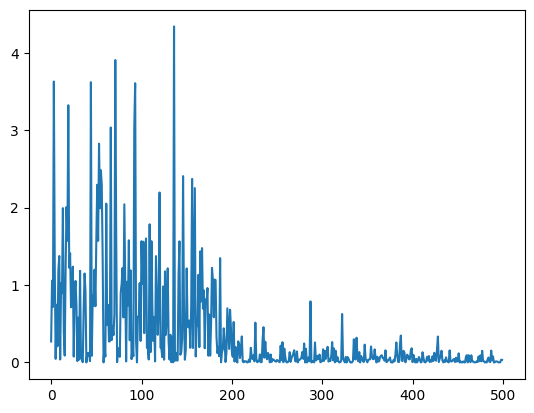

In [12]:

rnn, losses = train_rnn(data_train, num_steps=500)

plt.plot([i for i in range(len(losses))], losses)
plt.show()

If you did everything correctly, the loss should have converged to below 0.075:

In [13]:

assert torch.mean(torch.tensor(losses[-25:])) < 0.075

#### Evaluation on the test set

Let us now use the network to predict the samples in the test set and plot predicted versus true value:

In [14]:

ys = []
y_hats = []

for i in range(len(data_test) - 24):
    x = data_test[i: i + 24]
    y = data_test[i + 24, 1]
    _, y_hat = rnn(x)

    ys.append(float(y))
    y_hats.append(float(y_hat))


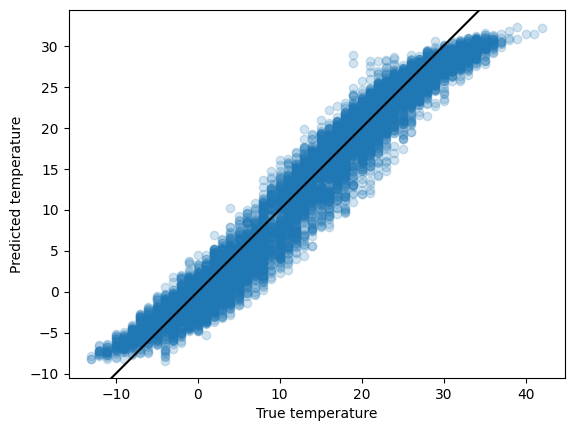

In [15]:
# transform the ys and y_hats to original scale
ys = torch.tensor(ys) * stds[1] + means[1]
y_hats = torch.tensor(y_hats) * stds[1] + means[1]
plt.scatter(ys, y_hats, alpha=0.2)
plt.axline((1, 1), slope=1, c='black')
# plot should be square
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('True temperature')
plt.ylabel('Predicted temperature')
plt.show()